In [1]:
import numpy as np
from scipy.linalg import solve_lyapunov, inv, solve_continuous_are
from numpy.linalg import inv, norm, det
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy import random
from scipy import optimize
from scipy import signal
from numpy import linalg
import plotly.express as px
import plotly.graph_objects as go
import plotly
import time
from IPython.display import clear_output, display, Math, Latex
from itertools import cycle
np.random.seed(0)

In [82]:
R = np.ones(1).reshape((1,1))
K = 0.01*np.ones(1).reshape((1,1))
B = 0.5*np.ones(1).reshape((1,1))
A = 0*np.ones(1).reshape((1,1))
Q = np.ones(1).reshape((1,1))

solve_subproblem(1, grad(K, Q, R, A, B), K, Q, R, A, B, C = None, SIGMA = None)

array([[1.]])

In [75]:
def func(K, Q, R, A, B, C = None, SIGMA = None):
    if C is None:
        C = np.eye(A.shape[0])
    if SIGMA is None:
        SIGMA = np.eye(A.shape[0])
    X = solve_lyapunov((A-B@K@C).transpose(), -Q-(K@C).transpose()@R@K@C)
    return np.trace(X@SIGMA)
def grad(K, Q, R, A, B, C = None, SIGMA = None):
    if C is None:
        C = np.eye(A.shape[0])
    if SIGMA is None:
        SIGMA = np.eye(A.shape[0])
    Ak = A-B@K@C
    X = solve_lyapunov(Ak.transpose(), -Q-(K@C).transpose()@R@K@C)
    Y = solve_lyapunov(Ak, -SIGMA)
    return 2*(R@K@C - B.transpose()@X)@Y@C.transpose()
def h(K, Q, R, A, B, C = None, SIGMA = None):
    return 1 / np.sqrt(np.trace(K.transpose() @ R @ K ))
def grad_h(R, K, h_j):
    return -R @ K * h_j**3
def solve_subproblem(L, gr, K, Q, R, A, B, C = None, SIGMA = None):
    #gr_f_j = grad(K, Q, R, A, B, C, SIGMA)
    gr_f_j = gr
    gr_h_j = grad_h(R, K, h(K, Q, R, A, B, C, SIGMA))
    C1 = gr_f_j / L - gr_h_j
    theta = 1 / (np.trace(C1.transpose() @ inv(R) @ C1))**(0.75)
    return theta * inv(R) @ C1
def calculate_L(K, Q, R, A, B, gr, f, C = None, SIGMA = None):
    if C is None:
        C = np.eye(A.shape[0])
    if SIGMA is None:
        SIGMA = np.eye(A.shape[0])
    lam_R, _ = linalg.eig(R)
    lam_n_R = lam_R[-1]
    lam_Q, _ = linalg.eig(Q)
    lam_1_Q = lam_Q[0]
    n = A.shape[0]
    norm_B = norm(B, ord = 2)
    norm_C = norm(C, ord = 2)
    norm_C_F = norm(C, ord = 'fro')
    alpha = max( 1 , (lam_n_R+f*(1+norm_B))/lam_1_Q )
    print(alpha)
    return 2*f/lam_1_Q*(lam_n_R*norm_C + 2*n*norm_B*norm_C_F*f*alpha)
def calculate_tighter_L(K, Q, R, A, B, gr, f, C = None, SIGMA = None):
    if C is None:
        C = np.eye(A.shape[0])
    if SIGMA is None:
        SIGMA = np.eye(A.shape[0])
    lam_R, _ = linalg.eig(R)
    lam_n_R = lam_R[-1]
    Ak = A-B@K
    n = A.shape[0]
    Y = solve_lyapunov(Ak, -SIGMA)
    X = solve_lyapunov(Ak.transpose(), -Q-(K@C).transpose()@R@K@C)
    norm_Y = norm(Y, ord = 2)
    norm_X = norm(X, ord = 2)
    norm_B = norm(B, ord = 2)
    norm_C_F = norm(C, ord = 'fro')
    CYCT = C@Y@C.transpose()
    lam_CYCT, _ = linalg.eig(CYCT)
    lam_n_CYCT = lam_CYCT[-1]
    gam = norm_X/norm_B + norm_X*norm_B
    alpha = 0.5*(gam + np.sqrt(gam + 4*lam_n_R))
    print(alpha)
    return 2*(lam_n_R*lam_n_CYCT + np.sqrt(n)*alpha*f*norm_C_F*norm_Y)
def calculate_L_with_X_prime(K, Q, R, A, B, gr, f, C = None, SIGMA = None):
    if C is None:
        C = np.eye(A.shape[0])
    if SIGMA is None:
        SIGMA = np.eye(A.shape[0])
    lam_R, _ = linalg.eig(R)
    lam_n_R = lam_R[-1]
    Ak = A-B@K@C
    n = A.shape[0]
    Y = solve_lyapunov(Ak, -SIGMA)
    X = solve_lyapunov(Ak.transpose(), -Q-(K@C).transpose()@R@K@C)
    norm_Y = norm(Y, ord = 2)
    norm_X = norm(X, ord = 2)
    norm_B = norm(B, ord = 2)
    norm_C_F = norm(C, ord = 'fro')
    CYCT = C@Y@(C.transpose())
    lam_CYCT, _ = linalg.eig(CYCT)
    lam_n_CYCT = lam_CYCT[-1]
    M = R@K@C - B.transpose()@X
    ME = M.transpose()@gr/norm(gr, ord = 'fro')
    X_pr = solve_lyapunov(Ak.transpose(), -(ME + ME.transpose()))
    norm_X_pr = norm(X_pr, ord = 'fro')
    return 2*(lam_n_R*lam_n_CYCT + norm_X_pr*norm_B*norm_C_F*norm_Y)
def calculate_action(K, Q, R, A, B, gr, C = None, SIGMA = None):
    if C is None:
        C = np.eye(A.shape[0])
    if SIGMA is None:
        SIGMA = np.eye(A.shape[0])
    Ak = A-B@K@C
    Y = solve_lyapunov(Ak, -SIGMA)
    X = solve_lyapunov(Ak.transpose(), -Q-(K@C).transpose()@R@K@C)
    M = R@K@C - B.transpose()@X
    MEC = M.transpose()@gr@C
    X_pr = solve_lyapunov(Ak.transpose(), -(MEC + MEC.transpose()))
    return 2*np.trace((R@gr@C - 2*B.transpose()@X_pr)@Y@C.transpose()@gr.transpose())
def update_plot(fs, Grads, K_norms, mode = None):
    clear_output(True)
    if mode == None:
        if np.all(C == np.eye(A.shape[0])): mode = 'state'
        else: mode = "output"
    if mode == "output":
        fig, axs = plt.subplots(1, 2, figsize=(15,8))
        axs[0].plot(fs)
        axs[0].set_xlabel(r'iteration, $j$', fontsize=10)
        axs[0].set_ylabel(r'$f(K_{j})$', fontsize=10)
        axs[0].grid()
        axs[1].plot(Grads)
        axs[1].set_xlabel(r'iteration, $j$', fontsize=10)
        axs[1].set_ylabel(r"$\left||\nabla f(K_{j})\right||$", fontsize=15)
        axs[1].grid()
        plt.show()
    elif mode == 'state':
        assert fs[-1] >= f_ric
        fig, axs = plt.subplots(1, 3, figsize=(15,8))
        axs[0].plot(np.log((fs-f_ric)/(fs[0]-f_ric)))
        axs[0].set_xlabel(r'iteration, $j$', fontsize=10)
        axs[0].set_ylabel(r'$log\left(\frac{f(K_{j})-f(K_*))}{f(K_0)-f(K_*)}\right)$', fontsize=15)
        axs[0].grid()
        axs[1].plot(Grads)
        axs[1].set_xlabel(r'iteration, $j$', fontsize=10)
        axs[1].set_ylabel(r"$\left||\nabla f(K_{j})\right||$", fontsize=15)
        axs[1].grid()
        axs[2].plot(np.log(K_norms/K_norms[0]))
        axs[2].set_xlabel(r'iteration, $j$', fontsize=10)
        axs[2].set_ylabel(r"$log\left(\frac{\||K_{j}-K_{*}\||}{\||K_{0}-K_{*}\||}\right)$", fontsize=15)
        axs[2].grid()
        plt.show()
def plot_all(fss, mode = None, y_bottom = None):
    lines = ["-","-.","--",":",'dotted','densely dotted','loosely dotted']
    linecycler = cycle(lines)
    if mode == None:
        if np.all(C == np.eye(A.shape[0])): mode = 'state'
        else: mode = "output"
    if mode == "output":
        fig, axs = plt.subplots(1, 1, figsize=(15,8))
        for fs, label in fss:
            axs.plot(fs, label = label, ls = next(linecycler))
            axs.set_xlabel('iteration, $j$', fontsize=10)
            axs.set_ylabel('$f(K_{j})$', fontsize=10)
        axs.grid()
        axs.legend()
        plt.show()
    elif mode == 'state':
        fig, axs = plt.subplots(1, 1, figsize=(15,8))
        for fs, label in fss:
            axs.plot(np.log((fs-f_ric)/(fs[0]-f_ric)), label = label, ls = next(linecycler))
            axs.set_xlabel(r'iteration, $j$', fontsize=10)
            axs.set_ylabel(r'$log\left(\frac{f(K_{j})-f(K_*))}{f(K_0)-f(K_*)}\right)$', fontsize=15)
        if y_bottom is not None:
            axs.set_ylim(bottom=y_bottom)
        axs.grid()
        axs.legend()
        plt.show()
def plot_all_K(Kss_norms, mode = None, y_bottom = None):
    lines = ["-","-.","--",":",'dotted','densely dotted','loosely dotted']
    linecycler = cycle(lines)
    if mode == None:
        if np.all(C == np.eye(A.shape[0])): mode = 'state'
        else: mode = "output"
    assert mode == "state"
    fig, axs = plt.subplots(1, 1, figsize=(15,8))
    for Ks, label in Kss_norms:
        axs.plot(np.log((Ks)/(Ks[0])), label = label, ls = next(linecycler))
        axs.set_xlabel(r'iteration, $j$', fontsize=10)
        axs.set_ylabel(r'$log\left(\frac{\|K_{j}-K_{*}\|}{\|K_{0}-K_{*}\|}\right)$', fontsize=15)
    if y_bottom is not None:
        axs.set_ylim(bottom=y_bottom)
    axs.grid()
    axs.legend()
    plt.show()

### Saddle Point Example

In [53]:
A = np.zeros((3,3))
A[0][1] = 1
A[1][2] = 1
A[2][0] = -1
A[2][1] = -1
A[2][2] = -1.1
B = np.zeros(3).reshape((3,1))
B[2][0] = 1
C = np.ones((2,3))
C[0][2] = 0
C[1][1] = -1
Q = np.eye(3)
R = np.eye(1)
K0 = np.array([[0,-0.5]])
K1 = np.array([[2.5,0.5]])
#K0 = 0.5*(K0+K1)

### 3-D minimal nonconvex example

In [54]:
Q = np.eye(3)
R = np.ones(1).reshape((1,1))
A = np.zeros((3,3))
A[0][1] = 1
A[1][2] = 1
B = np.zeros(3).reshape((3,1))
B[2][0] = 1
C = np.eye(3)
K0 = np.array([[8, 3, 3]]).reshape((1,3))

P = solve_continuous_are(A, B, Q, R)
K_ric = inv(R)@B.transpose()@P
f_ric = func(K_ric, Q, R, A, B)
display(Math('f(K_{0}) = '+str(func(K0, Q, R, A, B))))
display(Math(r"\nabla f(K_0) = " + str(grad(K0, Q, R, A, B))))
display(Math('f(K_{ric}) = '+str(f_ric)))
display(Math(r"||\nabla f(K_{ric})|| = " + str(grad(K_ric, Q, R, A, B))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Large scale example

In [19]:
%%time 
n = 10
m = 5
Q = random.rand(n,n)
Q = 0.25*(Q+Q.transpose()) + np.eye(n)
R = random.rand(m, m).reshape((m,m))
R = 0.25*(R+R.transpose()) + np.eye(m)
C = np.eye(n)
i=0
while True:
    B = np.ones((n,m))+0.5*random.rand(n, m).reshape((n,m))
    #K0 = -random.rand(m, n).reshape((m,n))
    A = 0.25*random.rand(n,n) - np.eye(n)
    zero_ones_1 = complex(0, 1)*np.random.randint(2, size=n//2)
    zero_ones_2 = complex(0, 1)*np.random.randint(2, size=n//2)
    zero_ones_3 = complex(0, 1)*np.random.randint(2, size=n//2)
    P0 = np.append(np.linspace(-3, -1, n//2) + zero_ones_1, np.linspace(-3, -1, n//2) - zero_ones_1)
    P1 = np.append(np.linspace(-3, -1, n//2) + zero_ones_2, np.linspace(-3, -1, n//2) - zero_ones_2)
    P2 = np.append(np.linspace(-3, -1, n//2) + zero_ones_3, np.linspace(-3, -1, n//2) - zero_ones_3)
    fsf0 = signal.place_poles(A, B, P0, method='YT', rtol=0.001)
    fsf1 = signal.place_poles(A, B, P1, method='YT', rtol=0.001)
    fsf2 = signal.place_poles(A, B, P2, method='YT', rtol=0.001)
    K0 = fsf0.gain_matrix
    K1 = fsf1.gain_matrix
    K2 = fsf2.gain_matrix
    #print(i)
    i+=1
    if np.all(np.linalg.eigvals(A-B@K0) < -0.7) and np.all(np.linalg.eigvals(A-B@K1) < -0.7) and np.all(np.linalg.eigvals(A-B@K2) < -0.7):
        break
    else:
        print(max(np.linalg.eigvals(A-B@K0)), max(np.linalg.eigvals(A-B@K1)), max(np.linalg.eigvals(A-B@K2)))
print(np.linalg.eigvals(A-B@K0))
P = solve_continuous_are(A, B, Q, R)
K_ric = inv(R)@B.transpose()@P
f_ric = func(K_ric, Q, R, A, B)
display(Math('f(K_{0}) = '+str(func(K0, Q, R, A, B))))
display(Math(r"\|\nabla f(K_0)\| = " + str(norm(grad(K0, Q, R, A, B)))))
display(Math('f(K_{ric}) = '+str(f_ric)))
display(Math(r"\|\nabla f(K_{ric})\| = " + str(norm(grad(K_ric, Q, R, A, B)))))

[-3. +1.j -3. -1.j -2.5+1.j -2.5-1.j -1. +0.j -1. +0.j -1.5+0.j -1.5+0.j
 -2. +0.j -2. +0.j]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 948 ms, sys: 140 ms, total: 1.09 s
Wall time: 275 ms


In [55]:
def optimize_reference(func = func, 
                grad = grad, 
                gamma_strategy = 'steep_quad', 
                maxit=100, 
                gamma0 = 0.1, 
                delta = 0.5, 
                grad_eps = 1e-10,
                K_eps = 1e-5,
                K0 = K0,
                restarts = False
               ):
    Ks, K_norms, fs, Grads, drob_iters = [], [], [], [], []
    K = K0
    if np.all(C == np.eye(A.shape[0])): mode = "state"
    else: mode = "output"
    if gamma_strategy == 'const': gamma = gamma0

    for it in tqdm(range(maxit)):
        Ks.append(K)
        f = func(K, Q, R, A, B, C)
        fs.append(f)
        gr = grad(K, Q, R, A, B, C)
        Grads.append(norm(gr))
        if mode == "state":
            K_norms.append(norm(K-K_ric))
            
        if gamma_strategy == 'steep_quad':
            gamma = (norm(gr)**2)/calculate_action(K, Q, R, A, B, gr, C)
            if gamma <= 0: gamma = gamma0
        
        while max(np.linalg.eig(A-B@(solve_subproblem(1/gamma, gr, K, Q, R, A, B, C))@C)[0])> 0.0:
            print('droblenie on {}th iteration', it)
            drob_iters.append(it)
            gamma *= delta
            
        K = solve_subproblem(1/gamma, gr, K, Q, R, A, B, C)
        
        if it % maxit == maxit-1:
            update_plot(fs, Grads, K_norms)
            
        if norm(gr) < grad_eps:
            break
        if mode == "state" and K_norms[-1]/K_norms[0] < K_eps:
            break
    return K_norms, fs, drob_iters

In [56]:
def optimize_CG(func = func, 
                grad = grad, 
                gamma_strategy = 'steep_quad', 
                maxit = 100, 
                gamma0 = 0.1, 
                delta = 0.5, 
                grad_eps = 1e-10,
                K_eps = 1e-5,
                K0 = K0,
                beta_strategy = "PRP"
               ):
    Ks, K_norms, fs, Grads, drob_iters = [K0], [], [], [], []
    K = K0
    dK = 0*K0
    s = grad(K, Q, R, A, B, C)

    if np.all(C == np.eye(A.shape[0])): mode = "state"
    else: mode = "output"
        
    for it in tqdm(range(maxit)):
        Ks.append(K)
        
        f = func(K, Q, R, A, B, C)
        fs.append(f)
        gr = grad(K, Q, R, A, B, C)
        Grads.append(norm(gr))
        
        if mode == "state":
            K_norms.append(norm(K-K_ric))
        
        dK_old = dK
        dK = - gr
        if beta_strategy == "PRP":
            beta = np.trace(dK.transpose() @ (dK - dK_old)) / np.trace(dK.transpose() @ dK)
            beta = max(0, beta)
        if beta_strategy == "FR":
            beta = np.trace(dK.transpose()@dK) / np.trace(dK_old.transpose() @ dK_old)
        if it == 0: beta = 0
            
        s = dK + beta * s
        
        if gamma_strategy == 'steep_quad':
            gamma = np.trace(s.transpose()@dK)/calculate_action(K, Q, R, A, B, s, C)
            if gamma <= 0: gamma = gamma0
        elif gamma_strategy == 'const':
            gamma = gamma0
            
        while max(np.linalg.eig(A-B@(K + gamma*s)@C)[0]) > 0.0:
            print('droblenie on {}th iteration', it)
            drob_iters.append(it)
            s = dK
            gamma *= delta
                  
        K = K + gamma*s
        
        if it % maxit == maxit-1:
            update_plot(fs, Grads, K_norms)
            
        if norm(gr) < grad_eps:
            break
        if mode == "state" and K_norms[-1]/K_norms[0] < K_eps:
            break
    return K_norms, fs, drob_iters

In [57]:
def optimize_HB(func = func, 
                grad = grad, 
                gamma_strategy = 'steep_quad', 
                b = 0.7, 
                maxit=100, 
                gamma0 = 0.1, 
                delta = 0.5, 
                grad_eps = 1e-10,
                K_eps = 1e-5,
                K0 = K0,
                restarts = False
               ):
    Ks, K_norms, fs, Grads, drob_iters = [K0], [], [], [], []
    K = K0
    gr = grad(K, Q, R, A, B, C)
    
    if np.all(C == np.eye(A.shape[0])): mode = "state"
    else: mode = "output"
        
    for it in tqdm(range(maxit)):
        Ks.append(K)
        K_old = Ks[-2]
        
        f = func(K, Q, R, A, B, C)
        fs.append(f)
        gr_old = gr
        gr = grad(K, Q, R, A, B, C)
        Grads.append(norm(gr))
        if mode == "state":
            K_norms.append(norm(K-K_ric))

        if gamma_strategy == 'steep_quad':
            gamma = (norm(gr)**2)/calculate_action(K, Q, R, A, B, gr, C)
            if gamma <= 0: gamma = gamma0
        elif gamma_strategy == 'const':
            gamma = gamma0
        
        while max(np.linalg.eig(A-B@(K - gamma*gr + b*(K - K_old))@C)[0]) > 0.0:
            print('droblenie on {}th iteration', it)
            drob_iters.append(it)
            K_old = K
            gamma *= delta
            
        if restarts == True and np.trace(gr.transpose() @ (K - K_old)) < 0:
            K_old = K
            
        K = K - gamma*gr + b*(K - K_old)
        
        if it % maxit == maxit-1:
            update_plot(fs, Grads, K_norms)
            
        if norm(gr) < grad_eps:
            break
        if mode == "state" and K_norms[-1]/K_norms[0] < K_eps:
            break
    return K_norms, fs, drob_iters

In [58]:
def optimize_GD(func = func, 
                grad = grad, 
                gamma_strategy = 'steep_quad', 
                maxit = 100, 
                gamma0 = 0.1, 
                delta = 0.5, 
                grad_eps = 1e-10,
                K_eps = 1e-5,
                K0 = K0):
    Ks, K_norms, fs, Grads, drob_iters = [], [], [], [], []
    K = K0
    if np.all(C == np.eye(A.shape[0])): mode = "state"
    else: mode = "output"
        
    for it in tqdm(range(maxit)):
        Ks.append(K)
        f = func(K, Q, R, A, B, C)
        fs.append(f)
        gr = grad(K, Q, R, A, B, C)
        Grads.append(norm(gr))
        if mode == "state":
            K_norms.append(norm(K-K_ric))
            
        if gamma_strategy == 'steep_quad':
            gamma = (norm(gr)**2)/calculate_action(K, Q, R, A, B, gr, C)
            if gamma <= 0: gamma = gamma0
        elif gamma_strategy == 'const':
            gamma = gamma0
        #func(K - gamma*gr, Q, R, A, B, C) > func(K, Q, R, A, B, C) - eps*gamma*norm(gr)**2 or 
        while max(np.linalg.eig(A-B@(K - gamma*gr)@C)[0])> 0.0:
            print('droblenie on {}th iteration', it)
            drob_iters.append(it)
            gamma *= delta
            
        K = K - gamma*gr
        
        if it % maxit == maxit-1:
            update_plot(fs, Grads, K_norms)
            
        if norm(gr) < grad_eps:
            break
        if mode == "state" and K_norms[-1]/K_norms[0] < K_eps:
            break
    return K_norms, fs, drob_iters

In [66]:
MAXIT = 30
GAMMA0 = 0.01

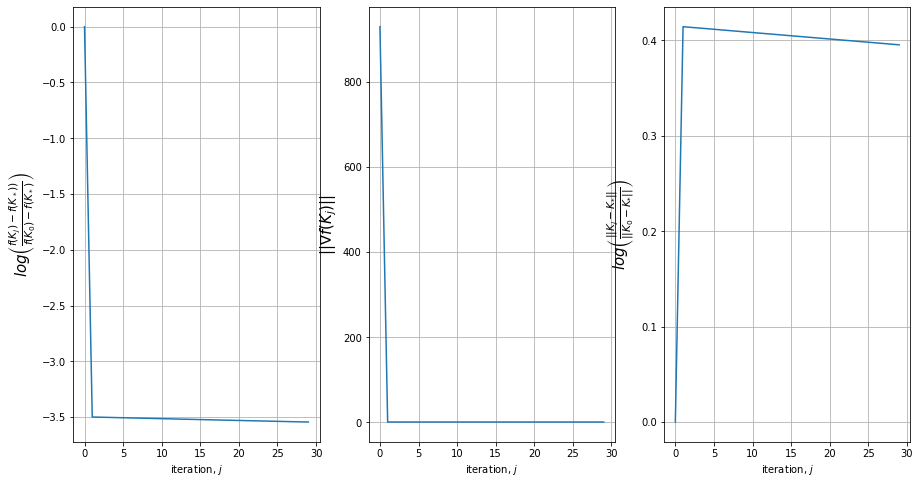

100%|██████████| 30/30 [00:00<00:00, 51.53it/s]


In [67]:
K_norms_GDN, fs_GDN, drob_iters_GDN = optimize_GD(maxit = MAXIT)
K_norms_GD, fs_GD, drob_iters_GD = optimize_GD(maxit = MAXIT, gamma_strategy="const", gamma0 = GAMMA0)

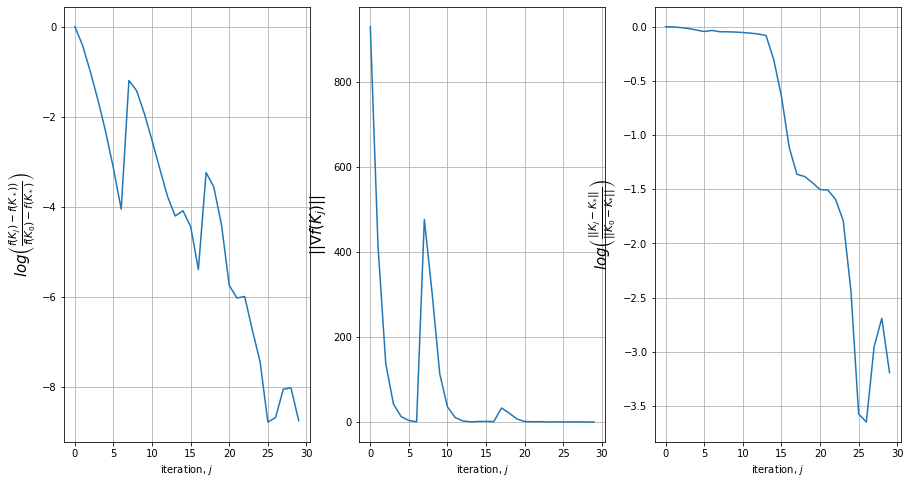

100%|██████████| 30/30 [00:00<00:00, 49.18it/s]


In [68]:
K_norms_HB, fs_HB, drob_iters_HB = optimize_HB(maxit = MAXIT, gamma_strategy="const", gamma0 = GAMMA0)
K_norms_HBN, fs_HBN, drob_iters_HBN = optimize_HB(maxit = MAXIT)

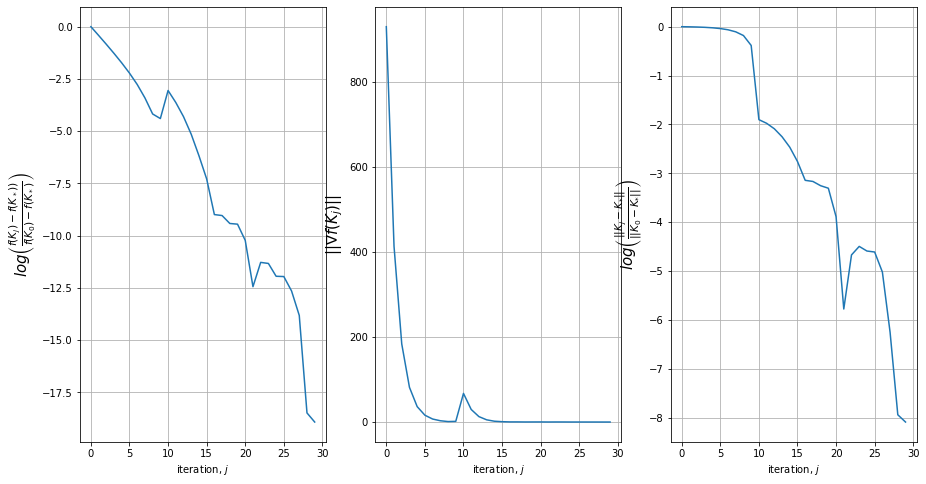

100%|██████████| 30/30 [00:00<00:00, 43.77it/s]


In [69]:
K_norms_CG, fs_CG, drob_iters_GD = optimize_CG(maxit = MAXIT, gamma_strategy="const", gamma0 = GAMMA0)
K_norms_CGN, fs_CGN, drob_iters_CGN = optimize_CG(maxit = MAXIT)

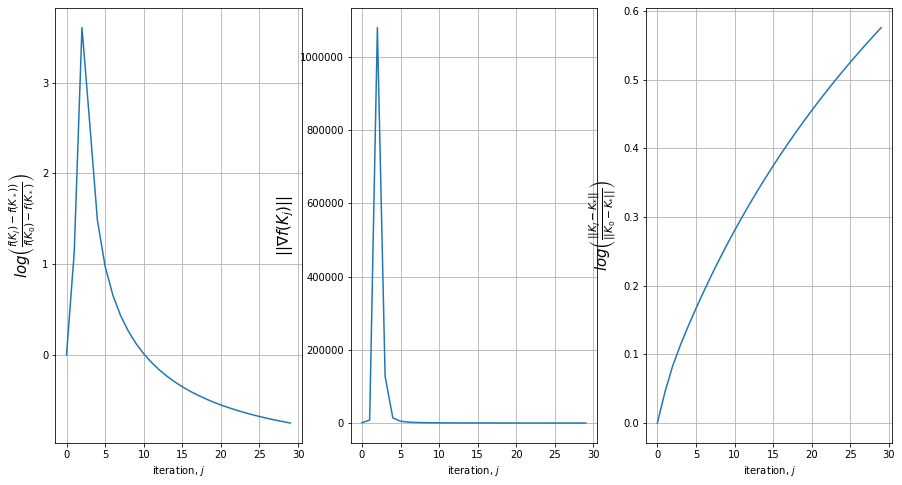

100%|██████████| 30/30 [00:00<00:00, 36.07it/s]


In [70]:
K_norms_ref, fs_ref, drob_iters_ref = optimize_reference(maxit = MAXIT, gamma_strategy="const", gamma0 = GAMMA0)
#K_norms_refN, fs_refN, drob_iters_refN = optimize_reference(maxit = MAXIT, gamma_strategy="steep_quad")

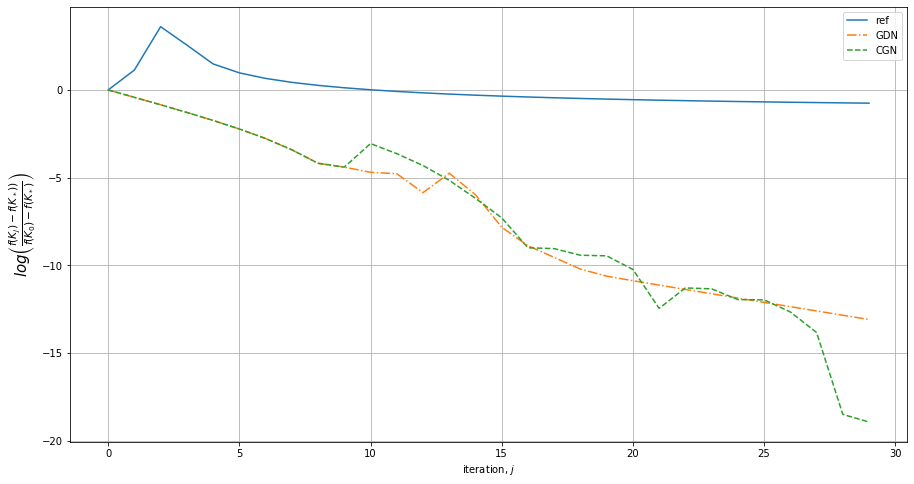

In [71]:
plot_all([(fs_ref, 'ref'), (fs_GDN, 'GDN'), (fs_CGN, "CGN")], y_bottom = None)

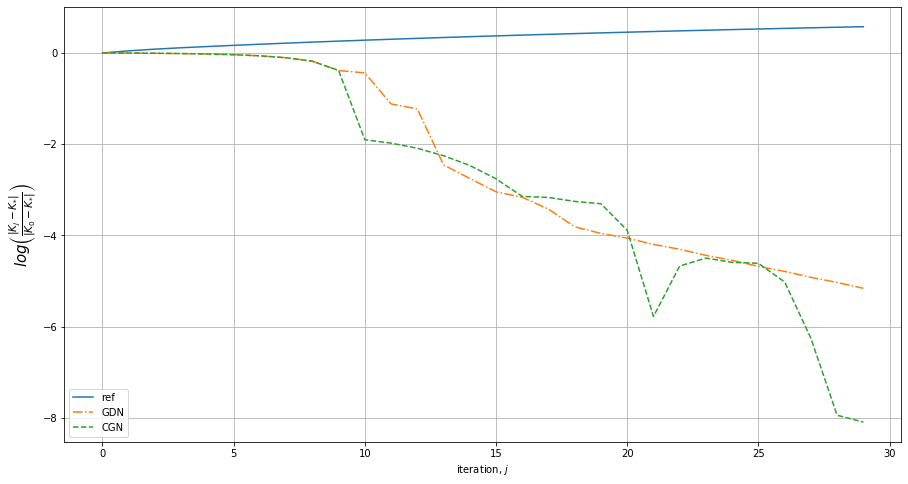

In [72]:
plot_all_K([(K_norms_ref, 'ref'), (K_norms_GDN, 'GDN'), (K_norms_CGN, 'CGN')])

In [15]:
drob_iters_HBN

[7]

In [16]:
drob_iters_CGN

[]

In [17]:
drob_iters_HB

[]

In [18]:
drob_iters_GDN

[]